In [2]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime

CMAP = "Blues"

# Coastal Erosion Notebook

# Under Development

## Summary
This notebook takes advantage of a time series of Landsat-8 to produce an annual coastline product. 

## Overview
This product is produced, by loading in Landsat-8 data on an annual basis. For each scene a wofs product is produced to identify pixels containing water, as well as cloud and shadows masked. (This step could be replaced in further iterations by using pre-loaded wofs products to increase the computatoinal efficiency). Each scene is matched with it's equivalent tidal height and filtered images within a certain tidal range. Summary annual products are then produced, then shorelines extracted. 

This notebook takes advantage of DASK.

## Install requirements

In [3]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

  Cloning https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git to /tmp/pip-install-arh905ix/datacube-utilities
  Running command git clone -q https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git /tmp/pip-install-arh905ix/datacube-utilities
  Using cached https://files.pythonhosted.org/packages/bd/f2/9f5f3cb42ce722aef3341cbbe7ed54aed6e198c75b5f08fcc1265eb3499d/Shapely-1.6.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d1/54/9d66ee2180776dfe33c2b8cc2f2b67c343fd9d80de91ac0edc5bc346fb06/Cython-0.29.15-cp36-cp36m-manylinux1_x86_64.whl
  Stored in directory: /tmp/pip-ephem-wheel-cache-72x3lvd5/wheels/6f/ca/99/cf843b6f692d630935e4c6e2b046adba8ed5f3a34052a76f11
Successfully built datacube-utilities
  Found existing installation: Shapely 1.6.4.post2
    Uninstalling Shapely-1.6.4.post2:
      Successfully uninstalled Shapely-1.6.4.post2


## Import Required DC utils

In [4]:
# import required datacube modules
from datacube_utilities.interactive_maps import display_map
from datacube_utilities.clean_mask import landsat_qa_clean_mask
import datacube_utilities.waterline_functions_deaafrica as waterline_funcs
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createAOI import create_lat_lon

import datacube
dc = datacube.Datacube(app='wofs dask')

[autoreload of shapely.coords failed: Traceback (most recent call last):
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 331, in update_generic
    update(a, b)
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 289, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 331, in update_generic
    update(a, b)
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 265, in update_function
    setattr(old, name, getattr(new, 

In [5]:
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')

### Set Variables

In [6]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"

aoi_wkt = "POLYGON((178.67520332337 -18.046588897702, 178.68601799012 -18.046588897702, 178.68610382081 -18.057231903073, 178.67537498475 -18.05740356445, 178.67520332337 -18.046588897702))"
#aoi_wkt = "POLYGON((178.68713378906 -17.997493743896, 178.69846343994 -18.00624847412, 178.68301391601 -18.024959564208, 178.67288589477 -18.017063140868, 178.67305755615 -18.017063140868, 178.68713378906 -17.997493743896))"

time_range = ("2000", "2019")

tide_range = (0.00, 10.00)

time_step = '1Y'

output_projection = "EPSG:32760"

res = (30)

In [7]:
#Set paths for tide data
#path = "/home/shared/geo_demos/tides/"
#tide_files = [path + 'IDO70004_2013.csv', path + '/IDO70004_2014.csv', path + '/IDO70004_2015.csv', path + '/IDO70004_2016.csv', path + '/IDO70004_2017.csv', path + '/IDO70004_2018.csv', path + '/IDO70004_2019.csv']


In [8]:
import glob
tide_files = glob.glob("/home/jovyan/odc-hub/tides/*.csv")

### Create AOI

In [9]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [10]:
waterline_funcs.display_map(latitude=lat_extents, longitude=lon_extents)

In [11]:
#create resolution
resolution = (-res, res)

In [12]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

### Import Landsat-8 data

In [13]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time provided above
query = {
    'y': lat_extents,
    'x': lon_extents,
    'time': time_range,
    'output_crs': output_projection,  
    'resolution': resolution,
    'dask_chunks': dask_chunks
}

#Import L8 scenes for the given period
scenes = dc.load(product="ls8_water_classification",
                 group_by='solar_day',
                 measurements = ['water_classification'],
                 **query
)

In [14]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'y': lat_extents,
    'x': lon_extents,
    'time': time_range,
    #'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_swir_1'],
    'resolution': resolution,
    'output_crs': output_projection,  
}


In [15]:
def load_ard(dc,
             products=None,
             min_gooddata=0.0,
             fmask_gooddata=[1, 4, 5],
             mask_pixel_quality=True,
             mask_invalid_data=True,
             mask_contiguity='nbart_contiguity',
             mask_dtype=np.float32,
             ls7_slc_off=True,
             product_metadata=False,
             **dcload_kwargs):
    '''
    Loads Landsat Collection 3 or Sentinel 2 Definitive and Near Real 
    Time data for multiple sensors (i.e. ls5t, ls7e and ls8c for 
    Landsat; s2a and s2b for Sentinel 2), and returns a single masked 
    xarray dataset containing only observations that contain greater 
    than a given proportion of good quality pixels. This can be used 
    to extract clean time series of observations that are not affected 
    by cloud, for example as an input to the `animated_timeseries` 
    function from `dea_plotting`.
    
    The proportion of good quality pixels is calculated by summing the 
    pixels flagged as good quality in `fmask`. By default non-cloudy or 
    shadowed land, snow and water pixels are treated as good quality, 
    but this can be customised using the `fmask_gooddata` parameter.
    
    Last modified: February 2020
    
    Parameters
    ----------  
    dc : datacube Datacube object
        The Datacube to connect to, i.e. `dc = datacube.Datacube()`.
        This allows you to also use development datacubes if required.    
    products : list
        A list of product names to load data from. Valid options are 
        ['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'] for Landsat,
        ['s2a_ard_granule', 's2b_ard_granule'] for Sentinel 2 Definitive, 
        and ['s2a_nrt_granule', 's2b_nrt_granule'] for Sentinel 2 Near 
        Real Time (on the DEA Sandbox only).
    min_gooddata : float, optional
        An optional float giving the minimum percentage of good quality 
        pixels required for a satellite observation to be loaded. 
        Defaults to 0.0 which will return all observations regardless of
        pixel quality (set to e.g. 0.99 to return only observations with
        more than 99% good quality pixels).
    fmask_gooddata : list, optional
        An optional list of fmask values to treat as good quality 
        observations in the above `min_gooddata` calculation. The 
        default is `[1, 4, 5]` which will return non-cloudy or shadowed 
        land, snow and water pixels. Choose from: 
        `{'0': 'nodata', '1': 'valid', '2': 'cloud', 
          '3': 'shadow', '4': 'snow', '5': 'water'}`.
    mask_pixel_quality : bool, optional
        An optional boolean indicating whether to apply the good data 
        mask to all observations that were not filtered out for having 
        less good quality pixels than `min_gooddata`. E.g. if 
        `min_gooddata=0.99`, the filtered observations may still contain 
        up to 1% poor quality pixels. The default of False simply 
        returns the resulting observations without masking out these 
        pixels; True masks them and sets them to NaN using the good data 
        mask. This will convert numeric values to floating point values 
        which can cause memory issues, set to False to prevent this.
    mask_invalid_data : bool, optional
        An optional boolean indicating whether invalid -999 nodata 
        values should be replaced with NaN. These invalid values can be
        caused by missing data along the edges of scenes, or terrain 
        effects (for NBART). Be aware that masking out invalid values 
        will convert all numeric values to floating point values when 
        -999 values are replaced with NaN, which can cause memory issues.
    mask_contiguity : str or bool, optional
        An optional string or boolean indicating whether to mask out 
        pixels missing data in any band (i.e. "non-contiguous" values). 
        Although most missing data issues are resolved by 
        `mask_invalid_data`, this step is important for generating 
        clean and concistent composite datasets. The default
        is `mask_contiguity='nbart_contiguity'` which will set any 
        pixels with non-contiguous values to NaN based on NBART data. 
        If you are loading NBAR data instead, you should specify
        `mask_contiguity='nbar_contiguity'` instead. To ignore non-
        contiguous values completely, set `mask_contiguity=False`.
        Be aware that masking out non-contiguous values will convert 
        all numeric values to floating point values when -999 values 
        are replaced with NaN, which can cause memory issues.
    mask_dtype : numpy dtype, optional
        An optional parameter that controls the data type/dtype that
        layers are coerced to when when `mask_pixel_quality=True` or 
        `mask_contiguity=True`. Defaults to `np.float32`, which uses
        approximately 1/2 the memory of `np.float64`.
    ls7_slc_off : bool, optional
        An optional boolean indicating whether to include data from 
        after the Landsat 7 SLC failure (i.e. SLC-off). Defaults to 
        True, which keeps all Landsat 7 observations > May 31 2003. 
    product_metadata : bool, optional
        An optional boolean indicating whether to return the dataset 
        with a `product` variable that gives the name of the product 
        that each observation in the time series came from (e.g. 
        'ga_ls5t_ard_3'). Defaults to False.
    **dcload_kwargs : 
        A set of keyword arguments to `dc.load` that define the 
        spatiotemporal query used to extract data. This typically
        includes `measurements`, `x`, `y`, `time`, `resolution`, 
        `resampling`, `group_by` and `crs`. Keyword arguments can 
        either be listed directly in the `load_ard` call like any 
        other parameter (e.g. `measurements=['nbart_red']`), or by 
        passing in a query kwarg dictionary (e.g. `**query`). For a 
        list of possible options, see the `dc.load` documentation: 
        https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html          
        
    Returns
    -------
    combined_ds : xarray Dataset
        An xarray dataset containing only satellite observations that 
        contains greater than `min_gooddata` proportion of good quality 
        pixels.   
        
    '''
    
    # Due to possible bug in xarray 0.13.0, define temporary function 
    # which converts dtypes in a way that preserves attributes
    def astype_attrs(da, dtype=np.float32):
        '''
        Loop through all data variables in the dataset, record 
        attributes, convert to a custom dtype, then reassign attributes. 
        If the data variable cannot be converted to the custom dtype 
        (e.g. trying to convert non-numeric dtype like strings to 
        floats), skip and return the variable unchanged.
        
        This can be combined with `.where()` to save memory. By casting 
        to e.g. np.float32, we prevent `.where()` from automatically 
        casting to np.float64, using 2x the memory. np.float16 could be 
        used to save even more memory (although this may not be 
        compatible with all downstream applications).
        
        This custom function is required instead of using xarray's 
        built-in `.astype()`, due to a bug in xarray 0.13.0 that drops
        attributes: https://github.com/pydata/xarray/issues/3348
        '''
        
        try:            
            da_attr = da.attrs
            da = da.astype(dtype)
            da = da.assign_attrs(**da_attr)
            return da
        
        except ValueError:        
            return da        
      

    # To prevent modifications to dcload_kwargs being made by this 
    # function remaining after the function is run (potentially causing 
    # different results each time the function is run), first take a 
    # deep copy of the dcload_kwargs object. 
    dcload_kwargs = deepcopy(dcload_kwargs)  
    
    # Determine if lazy loading is required
    lazy_load = 'dask_chunks' in dcload_kwargs
    
    # Warn user if they combine lazy load with min_gooddata
    if (min_gooddata > 0.0) & lazy_load:
                warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "
                              "will cause dask arrays to compute when "
                              "loading pixel-quality data to calculate "
                              "'good pixel' percentage. This can "
                              "significantly slow the return of your dataset.")
    
    # Verify that products were provided, and that only Sentinel-2 or 
    # only Landsat products are being loaded at the same time
    if not products:
        raise ValueError("Please provide a list of product names "
                         "to load data from. Valid options are: \n"
                         "['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'] " 
                         "for Landsat, ['s2a_ard_granule', "
                         "'s2b_ard_granule'] \nfor Sentinel 2 Definitive, or "
                         "['s2a_nrt_granule', 's2b_nrt_granule'] for "
                         "Sentinel 2 Near Real Time")
    elif all(['ls' in product for product in products]):
        product_type = 'ls'
    elif all(['s2' in product for product in products]):
        product_type = 's2'
    else:
        raise ValueError("Loading both Sentinel-2 and Landsat data "
                         "at the same time is currently not supported")

    # If `measurements` are specified but do not include fmask or 
    # contiguity variables, add these to `measurements`
    #to_drop = []  # store loaded var names here to later drop
    #fmask_band = 'fmask'
    
    #if 'measurements' in dcload_kwargs:        

     #   if fmask_band not in dcload_kwargs['measurements']:
          #  dcload_kwargs['measurements'].append(fmask_band)
           # to_drop.append(fmask_band)

      #  if (mask_contiguity and 
       #     (mask_contiguity not in dcload_kwargs['measurements'])):
        #    dcload_kwargs['measurements'].append(mask_contiguity)
         #   to_drop.append(mask_contiguity)  
            
    # If no `measurements` are specified, Landsat ancillary bands are loaded
    # with a 'oa_' prefix, but Sentinel-2 bands are not. As a work-around, 
    # we need to rename the default contiguity and fmask bands if loading
    # Landsat data without specifying `measurements`
    #elif product_type == 'ls': 
        #mask_contiguity = f'oa_{mask_contiguity}' if mask_contiguity else False
        #fmask_band = f'oa_{fmask_band}' 

    # Create a list to hold data for each product
    product_data = []

    # Iterate through each requested product
    for product in products:

        try:

            # Load data including fmask band
            print(f'Loading {product} data')
            try:
                
                # If dask_chunks is specified, load data using query
                if lazy_load:
                    ds = dc.load(product=f'{product}',
                                 **dcload_kwargs)
                
                # If no dask chunks specified, add this param so that
                # we can lazy load data before filtering by good data
                else:
                    ds = dc.load(product=f'{product}',
                                 dask_chunks={},
                                 **dcload_kwargs) 
                
            except KeyError as e:
                raise ValueError(f'Band {e} does not exist in this product. '
                                 f'Verify all requested `measurements` exist '
                                 f'in {products}')
            
            # Keep a record of the original number of observations
            total_obs = len(ds.time)
            print(total_obs)

            # Remove Landsat 7 SLC-off observations if ls7_slc_off=False
            #if not ls7_slc_off and product == 'ga_ls7e_ard_3':
             #   print('    Ignoring SLC-off observations for ls7')
              #  ds = ds.sel(time=ds.time < np.datetime64('2003-05-31'))

            # Identify all pixels not affected by cloud/shadow/invalid
            good_quality = ds
            
            # The good data percentage calculation has to load in all `fmask`
            # data, which can be slow. If the user has chosen no filtering 
            # by using the default `min_gooddata = 0`, we can skip this step 
            # completely to save processing time
            #if min_gooddata > 0.0:

                # Compute good data for each observation as % of total pixels
             #   data_perc = (good_quality.sum(axis=1).sum(axis=1) / 
              #      (good_quality.shape[1] * good_quality.shape[2]))

                # Filter by `min_gooddata` to drop low quality observations
#                ds = ds.sel(time=data_perc >= min_gooddata)
 #               print(f'    Filtering to {len(ds.time)} '
  #                    f'out of {total_obs} observations')
                
            # If any data was returned
            if len(ds.time) > 0:

                # Optionally apply pixel quality mask to observations 
                # remaining after the filtering step above to mask out 
                # all remaining bad quality pixels
                if mask_pixel_quality:
                    print('    Applying pixel quality/cloud mask')

                    # Change dtype to custom float before masking to 
                    # save memory. See `astype_attrs` func docstring 
                    # above for details  
                    ds = ds.apply(astype_attrs, 
                                  dtype=mask_dtype, 
                                  keep_attrs=True)
                    ds = ds.where(good_quality)
                    
                # Optionally filter to replace no data values with nans
                if mask_invalid_data:
                    print('    Applying invalid data mask')

                    # Change dtype to custom float before masking to 
                    # save memory. See `astype_attrs` func docstring 
                    # above for details           
                    ds = ds.apply(astype_attrs, 
                                  dtype=mask_dtype, 
                                  keep_attrs=True)
                    ds = masking.mask_invalid_data(ds)

                # Optionally apply contiguity mask to observations to
                # remove pixels missing data in any band
                #if mask_contiguity:
                #    print('    Applying contiguity mask')

                    # Change dtype to custom float before masking to 
                    # save memory. See `astype_attrs` func docstring 
                    # above for details   
                 #   ds = ds.apply(astype_attrs, 
                  #                dtype=mask_dtype, 
                   #               keep_attrs=True)                    
                    #ds = ds.where(ds[mask_contiguity] == 1)   

                # Optionally add satellite/product name as a new variable
                #if product_metadata:
                 #   ds['product'] = xr.DataArray(
                  #      [product] * len(ds.time), [('time', ds.time)])

                # If any data was returned, add result to list
                product_data.append(ds)
               
            # If no data is returned, print status
            else:
                print(f'    No data for {product}')
                

            # If  AttributeError due to there being no variables in
            # the dataset, skip this product and move on to the next
        except AttributeError:
            print(f'    No data for {product}')
               # If any data was returned above, combine into one xarray
    if (len(product_data) > 0):
        # Concatenate results and sort by time
        print(f'Combining and sorting data')
        combined_ds = xr.concat(product_data, dim='time').sortby('time')
        
        # If `lazy_load` is True, return data as a dask array without
        # actually loading it in
        if lazy_load:
            print(f'    Returning {len(combined_ds.time)} observations'' as a dask array')
            return combined_ds
        else:
            print(f'    Returning {len(combined_ds.time)} observations ')
            return combined_ds.compute()

            # If no data was returned:
    else:
        print('No data returned for query')
        return None

In [16]:
from copy import deepcopy

In [17]:
# Load available data from all three Landsat satellites
#from datacube_utilities.dea_datahandling import load_ard
landsat_ds = load_ard(dc=dc,
                      products=['ls8_water_classification', 
                                'ls7_water_classification',
                                'ls5_water_classification',
                                'ls4_water_classification'],
                      group_by='solar_day',
                      mask_invalid_data=False,
                      mask_pixel_quality=False,
                      dask_chunks = {},
                      **query)

Loading ls8_water_classification data
283
Loading ls7_water_classification data
312
Loading ls5_water_classification data
    No data for ls5_water_classification
Loading ls4_water_classification data
    No data for ls4_water_classification
Combining and sorting data
    Returning 595 observations as a dask array


In [18]:
#water_classes.isel(time = 4).water_classification.plot();
water_classes = dask.delayed(landsat_ds.where(landsat_ds >= 0))

In [19]:
water_classes_comp = water_classes.compute()

In [20]:
print(water_classes_comp)

<xarray.Dataset>
Dimensions:  (time: 595, x: 40, y: 41)
Coordinates:
  * y        (y) float64 8.004e+06 8.004e+06 8.004e+06 ... 8.003e+06 8.003e+06
  * x        (x) float64 6.773e+05 6.773e+05 6.774e+05 ... 6.784e+05 6.785e+05
  * time     (time) datetime64[ns] 2000-02-02 2000-02-27 ... 2019-09-10T22:06:52
Data variables:
    water    (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
Attributes:
    crs:      EPSG:32760


In [21]:
#apply wofs classifier from utils. 
#clearsky_masks = landsat_qa_clean_mask(scenes, 'LANDSAT_8')
#clearsky_scenes = scenes.where(clearsky_masks)
#water_classes = wofs_classify(scenes, clean_mask=clearsky_masks.values , no_data = np.nan , x_coord='x', y_coord = "y")

In [22]:
#plot an example scene
#wc_l8.isel(time = 1).wofs.plot(cmap='RdBu');

In [23]:
print(tide_files)

['/home/jovyan/odc-hub/tides/IDO70004_2004.csv', '/home/jovyan/odc-hub/tides/IDO70004_2012.csv', '/home/jovyan/odc-hub/tides/IDO70004_2010.csv', '/home/jovyan/odc-hub/tides/IDO70004_2015.csv', '/home/jovyan/odc-hub/tides/IDO70004_1995.csv', '/home/jovyan/odc-hub/tides/IDO70004_2013.csv', '/home/jovyan/odc-hub/tides/IDO70004_1996.csv', '/home/jovyan/odc-hub/tides/IDO70004_2006.csv', '/home/jovyan/odc-hub/tides/IDO70004_2001.csv', '/home/jovyan/odc-hub/tides/IDO70004_2000.csv', '/home/jovyan/odc-hub/tides/IDO70004_2017.csv', '/home/jovyan/odc-hub/tides/IDO70004_1998.csv', '/home/jovyan/odc-hub/tides/IDO70004_2016.csv', '/home/jovyan/odc-hub/tides/IDO70004_2009.csv', '/home/jovyan/odc-hub/tides/IDO70004_1993.csv', '/home/jovyan/odc-hub/tides/IDO70004_2002.csv', '/home/jovyan/odc-hub/tides/IDO70004_1992.csv', '/home/jovyan/odc-hub/tides/IDO70004_1994.csv', '/home/jovyan/odc-hub/tides/IDO70004_1997.csv', '/home/jovyan/odc-hub/tides/IDO70004_2011.csv', '/home/jovyan/odc-hub/tides/IDO70004_20

In [24]:
import pandas as pd
from pandas import DataFrame

In [74]:
df_list =[]

for f in tide_files:
    tide_data =pd.read_csv(f)
    df = tide_data
    #print('FIRST', df.head())
    #where tide_data['SE']
    #tide_data['tide'] = tide_data['Sea Level'].drop('Sea Level')
    #print(tide_data.head())
    #d = {'Sea Level': 'tide'}
    #tide_data.rename(columns={k: v for k, v in d.iteritems() if v not in df}, inplace=True)
    

# Check if the updated price is available or not 
    if 'Sea Level' in df.columns: 
        df['tides'] = df['Sea Level']
        df2 = DataFrame.drop(df, columns=['Sea Level'])
    else: 
        print('variables correct')
    #print(df2.head())
    if ' Date & UTC Time' in df2.columns:
        df2['time'] = df2[' Date & UTC Time']
        df2 = DataFrame.drop(df2, columns=[' Date & UTC Time'])
    else:
        print('variable2 correct')
    #print('SECOND',df2.head())
    df_list.append(df2)
tide_data = pd.concat(df_list)
#print('first', tide_data.head(1))
tide_data['time'] = pd.to_datetime(tide_data['time'], format='%d-%b-%Y %H:%M')
#print('second', tide_data.head(1))

variables correct
variable2 correct
variables correct
variable2 correct
variables correct
variable2 correct
variables correct
variable2 correct
variables correct
variable2 correct
variables correct
variable2 correct


### Import tide height data 
Into pandas and concatenate each year together.

Shoreline location varies with tides, only tide heights at specific conditions are kept - determined by tide_range setting. If tide_range values at 0.00, 2.00 then only tides between 0 and 2m relative to Mean Sea Level are kept. 

In [75]:
# the data here comes from http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml for fiji

#year_files = []
#for f in tide_files:
#    tide_data = pd.read_csv(f, parse_dates=['time'], index_col='time')
#    year_files.append(tide_data)
    
#tide_data = pd.concat(year_files)
#print(tide_data.head())
#tide_data_2013 = pd.read_csv(tide_file_2013, parse_dates=['time'], index_col='time')
#tide_data_2017 = pd.read_csv(tide_file_2017, parse_dates=['time'], index_col='time')
#tide_data_2018 = pd.read_csv(tide_file_2018, parse_dates=['time'], index_col='time')
#tide_data_2013['tide'] = tide_data_2013['Sea Level']
#tide_data_2016 = pd.read_csv(tide_file_2016, parse_dates= ['time'], index_col="time")
#tide_data = pd.concat([tide_data_2013, tide_data_2017])


In [76]:
tide_data['tide_height'] = tide_data['tides']

In [77]:
print(tide_data)

      Water Temperature  Air Temperature  Barometric Pressure  Residuals  \
0                  30.1             29.0               1001.8      0.023   
1                  30.1             28.8               1001.5      0.008   
2                  30.1             29.2               1000.8      0.030   
3                  30.2             29.2               1000.0      0.032   
4                  30.2             29.0                999.7      0.037   
5                  30.3             29.2               1000.6      0.021   
6                  30.4             29.1               1001.1      0.021   
7                  30.6             29.3               1001.8      0.035   
8                  30.5             29.1               1002.5      0.024   
9                  30.6             27.5               1003.2      0.021   
10                 30.5             27.9               1003.6      0.011   
11                 30.5             27.7               1003.6      0.015   
12          

In [87]:
new = tide_data.set_index('time')
print(new)

                     Water Temperature  Air Temperature  Barometric Pressure  \
time                                                                           
2004-01-01 00:00:00               30.1             29.0               1001.8   
2004-01-01 01:00:00               30.1             28.8               1001.5   
2004-01-01 02:00:00               30.1             29.2               1000.8   
2004-01-01 03:00:00               30.2             29.2               1000.0   
2004-01-01 04:00:00               30.2             29.0                999.7   
2004-01-01 05:00:00               30.3             29.2               1000.6   
2004-01-01 06:00:00               30.4             29.1               1001.1   
2004-01-01 07:00:00               30.6             29.3               1001.8   
2004-01-01 08:00:00               30.5             29.1               1002.5   
2004-01-01 09:00:00               30.6             27.5               1003.2   
2004-01-01 10:00:00               30.5  

In [88]:
df3 = new.loc[~new.index.duplicated(keep='first')]
print(df3)

                     Water Temperature  Air Temperature  Barometric Pressure  \
time                                                                           
2004-01-01 00:00:00               30.1             29.0               1001.8   
2004-01-01 01:00:00               30.1             28.8               1001.5   
2004-01-01 02:00:00               30.1             29.2               1000.8   
2004-01-01 03:00:00               30.2             29.2               1000.0   
2004-01-01 04:00:00               30.2             29.0                999.7   
2004-01-01 05:00:00               30.3             29.2               1000.6   
2004-01-01 06:00:00               30.4             29.1               1001.1   
2004-01-01 07:00:00               30.6             29.3               1001.8   
2004-01-01 08:00:00               30.5             29.1               1002.5   
2004-01-01 09:00:00               30.6             27.5               1003.2   
2004-01-01 10:00:00               30.5  

In [95]:
df4 = df3[df3.tides != -9999]

tides <xarray.Dataset>
Dimensions:              (time: 183557)
Coordinates:
  * time                 (time) datetime64[ns] 2004-01-01 ... 2003-12-31T23:00:00
Data variables:
    Water Temperature    (time) float64 30.1 30.1 30.1 30.2 ... 29.9 29.9 29.9
    Air Temperature      (time) float64 29.0 28.8 29.2 29.2 ... 29.5 28.7 28.7
    Barometric Pressure  (time) float64 1.002e+03 1.002e+03 ... 1.002e+03
    Residuals            (time) float64 0.023 0.008 0.03 ... 0.037 0.051 0.024
    Adjusted Residuals   (time) float64 -0.093 -0.106 -0.087 ... -0.061 -0.092
    Wind Direction       (time) int64 284 287 281 296 296 ... 58 47 4 272 285
    Wind Gust            (time) float64 3.9 3.7 4.2 4.0 4.4 ... 2.8 2.7 2.6 4.4
    Wind Speed           (time) float64 2.0 2.6 2.0 2.6 3.7 ... 2.0 1.1 2.1 3.6
    Lautoka              (time) float64 nan nan nan nan nan ... nan nan nan nan
     Fiji                (time) float64 nan nan nan nan nan ... nan nan nan nan
    tides                (time) float6

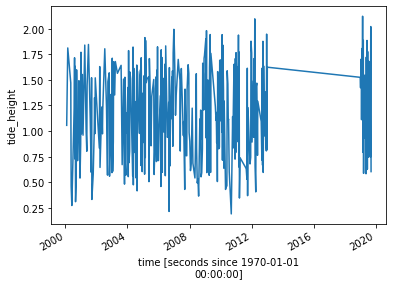

In [96]:
# First, we convert the data to an xarray dataset so we can analyse it in the same way as our Landsat data
tide_data_xr = df4.to_xarray()
print('tides', tide_data_xr)
# We want to convert our hourly tide heights to estimates of exactly how high the tide was at the time that
# each satellite image was taken. To do this, we can use `.interp` to 'interpolate' a tide height for each
# Landsat timestamp:
print('image', water_classes_comp.time)

landsat_tideheights = tide_data_xr.interp(time=water_classes_comp.time)

# We then want to put these values back into the Landsat dataset so that each image has an estimated tide height:
water_classes_comp['tide_height'] = landsat_tideheights.tide_height

# Plot the resulting tide heights for each Landsat image:
water_classes_comp.tide_height.plot()

plt.show()

### Filter Landsat Images by tide height

Only keep the Landsat Images which correspond to the desired tide height.

In [ ]:
landsat_hightide = water_classes_comp.where((water_classes_comp.tide_height > tide_range[0]) & 
                                   (water_classes_comp.tide_height < tide_range[1]), drop=True)
landsat_hightide.water.isel(time=3).plot(cmap='YlOrRd', size=6, vmin=-0.5, vmax=0.5)

### Create Summary Images of Water.

In [ ]:
landsat_resampled = landsat_hightide.water.compute().resample(time=time_step).max('time')
landsat_resampled.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

In [ ]:
#convert values to binary based on threshold of 0.5
for i in landsat_resampled.values:
    np.where(i < 0.5, i, 0*i)
    np.where(i >= 0.5, i, 0*i)

### Extract Shorelines from Imagery

In [ ]:
# Set up attributes to assign to each waterline
attribute_data = {'time': [str(i)[0:10] for i in landsat_resampled.time.values]}
attribute_dtypes = {'time': 'str'}

contour_gdf = waterline_funcs.contour_extract(
    z_values=[0.8],
    ds_array=landsat_resampled,
    ds_crs=scenes.crs,
    ds_affine=scenes.geobox.transform,
    output_shp=f'output_waterlines.shp',
    attribute_data=attribute_data,
    attribute_dtypes=attribute_dtypes,
    min_vertices=5
)

# Plot output shapefile over the top of the first year's MNDWI layer
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
landsat_resampled.isel(time=-1).plot(ax=ax, cmap='Greys', alpha=1.0, edgecolors=None)
contour_gdf.plot(cmap='YlOrRd', ax=ax)


In [ ]:
print(contour_gdf.head())

### Plot Interactive map of output shorelines coloured by time

In [ ]:
waterline_funcs.map_shapefile(gdf=contour_gdf)

In [ ]:
contour = contour_gdf[3:4]
waterline_funcs.map_shapefile(gdf=contour)


In [ ]:
contour1 = contour_gdf[1:2]
print(contour1)
waterline_funcs.map_shapefile(gdf=contour1)

In [ ]:
contour1 = contour_gdf[0:1]
print(contour1)
waterline_funcs.map_shapefile(gdf=contour1)

In [ ]:
client.restart()